# Sparse Representation for Color Image Restoration
- https://ieeexplore.ieee.org/document/4392496


### Tabitha Weinbrenner
### Jonah Wehner


In [3]:
# ALL PACKAGES WE NEED FROM PYTHON, add more as we complete notebook:

import numpy as np
import cv2
import scipy.linalg
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage import data, img_as_float
from time import time
import argparse
import matplotlib.pyplot as plt
import pdb
from PIL import Image
from numpy import*

# For K-SVD:
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

# For algorithm/Sparse Coding:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.exposure import rescale_intensity
from sklearn.feature_extraction.image import extract_patches_2d


## General Summary of Sparse Representation for Color Image Restoration:

#### The authors put forward algorithms addressing several different tasks, such as denoising of color images, denoising with nonuniform noise, inpainting small holes of color images, and demosaicing.

## What algorithms/methods will be used? (Project Description)

- Briefly Defines Sparse Coding, OMP, KSVD, Denoising, any remaining methods.


- **Dictionary learning** is the method of learning a matrix, such that we can write a signal as a linear combo of as few columns from the dictionary matrix as possible. This is why it is considered, **Sparse Coding.** 

- We intend to use this method, along with **Orthogonal Matching Pursuit**, a sparse approximation algorithm which finds the "best matching" projections of multidimensional data onto the span of an over-complete dictionary, to denoise grayscale images, as well as denoising using SVD methods from class for RGB, like **low rank approximations.** This is where we denoise the data by estimating the underlying structured low-rank matrix by it's singular values, using SVD.

- **INSERT PART C METHOD HERE**

# Part A: Denoising Grayscale Images

**METHOD EXPLANATION:** 

For this portion, we first chose a grayscale image, then applied distortion to this image. We then extracted patches from this distorted version, and used these to train/fit the dictionary. We then extracted noisy patches from the image again, and used the trained dictionary to reconstruct the image. This was done using the Orthogonal Matching Pursuit algorithm, which minimizes differences an image and optimizes the process by recursively, such that the resulting image would be denoised by rebuilding the sprase representation, through the OMP method.

**How it relates to the research paper, Sparse Representation for Color Image Restoration:**

In the journal, they use this dictionary method with OMP, but they include an additonal step: K-SVD. This step was difficult for us to implement, due to scikit learn having clustering and k-means methods, but not specifically a K-SVD method. It was above the level of difficulty in this course to recreate their algorithm form scratch to include this step, so we produced results of denoising without it.

Journal explanation for their use of K-SVD:  First, the OMP stops when the approximation reaches a sphere of radius in the patches’ space in order not to reconstruct the noise. Then, the SVD selects an “average” new direction for each atom, which rejects noise from the dictionary.

### Generate and Display Distorted Image

In [10]:
# Upload image:
img = cv2.imread("bird.jpeg")

# Turn into 2d array:
bird = img[:,:,0]

# convert to floats for accurate computations
bird = img_as_float(bird)  
height, width = bird.shape

# Distort the right half of the image with noise:
distorted = bird.copy()
distorted[:, width // 2 :] += 0.075 * np.random.randn(height, width // 2)

Difference from the normal image:  28.67627521090818


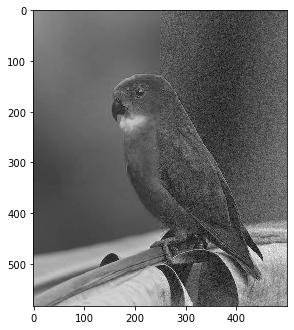

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(distorted,cmap=plt.cm.gray,interpolation="nearest")

# Difference from the normal image:
difference = distorted-bird
diff = np.sqrt(np.sum(difference**2))
print("Difference from the normal image: ",diff)

# Only right side should be distorted!

### Extracting Patches for Training Dictionary

In [14]:
from sklearn.feature_extraction.image import extract_patches_2d
# Reshape a 2D image into a collection of patches.

# Extract all reference patches from the left half of the image:
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, : width // 2], (7, 7))
data = data.reshape(data.shape[0], -1)

# Regularization:
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)

# Patches info:
print("Number of patches extracted:", data.shape[0], "Overall Time:", time()-t0)


Number of patches extracted: 140788 Overall Time: 0.09081029891967773


### Train the Dictionary Using the Reference Patches Extracted Above

In [15]:
from sklearn.decomposition import MiniBatchDictionaryLearning
# Finds a dictionary (a set of atoms) that performs well at sparsely encoding the fitted data.



t0 = time()
dico = MiniBatchDictionaryLearning(
    n_components=50, # Number of dictionary elements to extract.
    batch_size=200, # Number of samples in each mini-batch.
    alpha=1.0, #Sparsity controlling parameter.
    max_iter=10, # Maximum number of iterations over the complete dataset
)
V = dico.fit(data).components_ # Fitting the reference patches to dictionary.
dt = time() - t0 # Getting the time to run this model.


# Providing the iterations and steps taking by the model forming the dictionary:
print("Number of iterations: ", dico.n_iter_)
print("Number of steps: ", dico.n_steps_, "Over time period: ",dt )


Number of iterations:  1.0
Number of steps:  118 Over time period:  8.954864740371704


### Extract Noisy Patches, Reconstruct them via Dictionary, using OMP method

In [16]:
# Extracting the patches for transform -> reconstruction again:

t0 = time() # Tracking time:

# Reshape a 2D image into a collection of patches.
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
# Regularization:
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept

# Using the OMP algorithm from the project journal:
# 'omp': uses orthogonal matching pursuit to estimate the sparse solution.
transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
]

# Reconstructing the image using the algorithms:

reconstructions = {}

# For transform title, omp algorithm, and it's requirements:
for title, transform_algorithm, params in transform_algorithms:
    
    print(title)
    reconstructions[title] = bird.copy()
    t0 = time()
    
    # Set the parameters of this estimator, using OMP:
    dico.set_params(transform_algorithm=transform_algorithm, **params)
    
    # Use the reconstructed image patches to Encode the data as a sparse combination of the dictionary atoms.
    code = dico.transform(data) 
    
    # We want the the sparse representation and the Components extracted from the reference data.
    patches = np.dot(code, V)
    
    # Portion below taken from scikit example:
    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    
    # End time of reconstruction:
    dt = time() - t0
    
    print("Time: ",dt)

# Rebuild a sample starting from a sparse dictionary of atoms!

Orthogonal Matching Pursuit
1 atom
Time:  3.615778684616089
Orthogonal Matching Pursuit
2 atoms
Time:  7.581718683242798


### Display Results

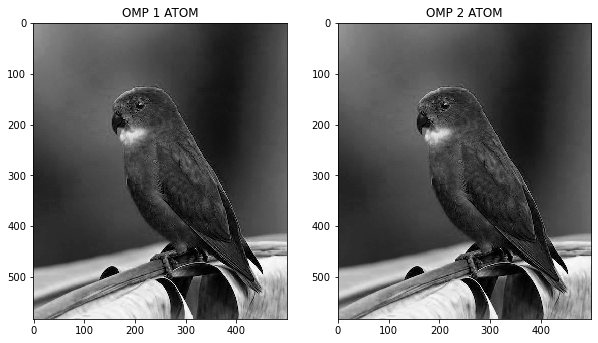

In [19]:
# Pull results:
omp_1 = reconstructions['Orthogonal Matching Pursuit\n1 atom']
omp_2 = reconstructions['Orthogonal Matching Pursuit\n2 atoms']

# Plot:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("OMP 1 ATOM")
#difference = omp_1-face
#diff = np.sqrt(np.sum(difference**2))
#print("Difference from the normal image: ",diff)
plt.imshow(omp_1, cmap=plt.cm.gray, interpolation="nearest")
    
plt.subplot(1, 2, 2)
#difference = omp_2-face
#diff = np.sqrt(np.sum(difference**2))
#print("Difference from the normal image: ",diff)
plt.title('OMP 2 ATOM')
plt.imshow(omp_2, cmap=plt.cm.gray, interpolation="nearest")
plt.show()

# Difference is minimal as image was easily reconstructed!

### B. Denoising of Color Images

In [31]:
# Read in the image:
image = cv2.imread("bird.jpeg")

# Extract the red, green, and blue channels:
(B, G, R) = cv2.split(image)

# Get the image dimensions:
h,w,d = image.shape
print("width = {}, height = {}, depth = {}".format(w, h, d))

width = 500, height = 583, depth = 3


(-0.5, 499.5, 582.5, -0.5)

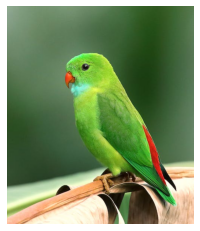

In [32]:
#display color image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rgb = np.array(image_rgb)
plt.imshow(image_rgb)
plt.axis('off')

**Adding Noise:**

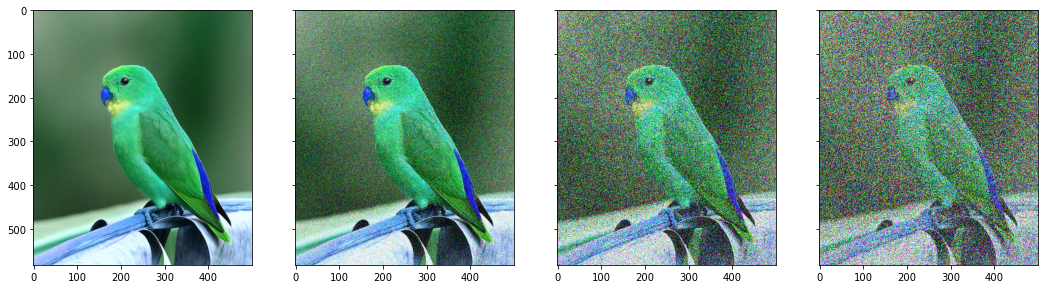

In [33]:
sigma = 0.155
original = img_as_float(image)  #convert to floats for accurate computations

noisy1 = random_noise(original, var=sigma**2)
noisy2 = random_noise(original, var=sigma**1)
noisy3 = random_noise(original, var=sigma**0.5)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 15), sharex=True, sharey=True)
ax[0].imshow(original)
ax[1].imshow(noisy1)
ax[2].imshow(noisy2)
ax[3].imshow(noisy3)

**Noise to Signal Ratio:**

In [34]:
SNR_noisy1 = (np.linalg.norm(image)/np.linalg.norm(noisy1-image))**2
print('SNR of noisy image 1 = ', SNR_noisy1)

SNR_noisy2 = (np.linalg.norm(image)/np.linalg.norm(noisy2-image))**2
print('SNR of noisy image 2 = ', SNR_noisy2)

SNR_noisy3 = (np.linalg.norm(image)/np.linalg.norm(noisy3-image))**2
print('SNR of noisy image 3 = ', SNR_noisy3)

SNR of noisy image 1 =  1.0077862310288288
SNR of noisy image 2 =  1.0076566133443017
SNR of noisy image 3 =  1.007564722190207


**Regular SVD:**

In [35]:
# Create matrix values of image:

A = np.matrix(image[:,:,1])

# Get SVD:
U, e, Vt = np.linalg.svd(A) # E is the vector of singular values!
U = np.matrix(U)
Vt = np.matrix(Vt)

# Generate compressed image using singular values:
e_matrix = np.zeros((583,500)) # Same size as A
for i in range(len(e_matrix[-1])):
    e_matrix[i,i] = e[i]

# Dsiplay/Generate New Image:
print(U*e_matrix*Vt)
new_im = U*e_matrix*Vt

[[170. 170. 170. ... 123. 123. 123.]
 [170. 170. 170. ... 123. 123. 123.]
 [170. 170. 170. ... 123. 123. 123.]
 ...
 [196. 195. 194. ... 217. 217. 213.]
 [194. 194. 191. ... 218. 218. 214.]
 [191. 191. 189. ... 217. 217. 212.]]


In [36]:
#This should be true to make sure SVD is correct:
np.allclose(A,new_im)

True

**We are now going to make a new image but only keep the, N, biggest singular values, while setting all of the rest to zero. First we define a new vector, S, consisting of the first N = 10  singular values:**

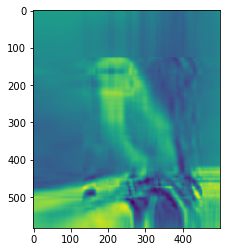

In [37]:
s = np.zeros((e.shape))
s[0:10] = e[0:10]

# Sigma matrix should be the same size as the original A matrix with mostly zero values:
S = np.zeros(A.shape)

# The upper left diagonal of the Sigma matrix should be the singular values:
S[:len(s), :len(s)] = np.diag(s)

# Compressed image
I = U*S*Vt

plt.imshow(I)

18.285161364307527


Text(0, 0.5, 'singular value')

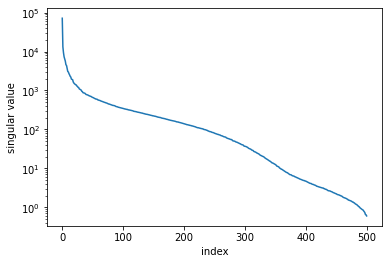

In [38]:
rmse = np.sqrt(((np.array(A)  - np.array(I)) ** 2).mean())
print(rmse)

plt.plot(e)
plt.gca().set_yscale('log')
plt.xlabel('index')
plt.ylabel('singular value')


### C. Color Image Inpainting (Also optional, if denoising grayscale/rgb is too short of code)
***Image inpainting is the art of modifying an image in an undetectable form, and it often refers to the filling-in of holes of missing information in the image.***

In [ ]:
# PART C: Do example of Color Image Inpainting.

### HELPFUL LINKS FOR PROJECT: (Sources)

#### (UPDATE CODE BLOCK WHEN FINISHED)

- Sparse Representation for Color Image Restoration LINK: https://ieeexplore.ieee.org/document/4392496

#### Definitions: 

***For Part A/B***
- https://en.wikipedia.org/wiki/Gaussian_noise
- https://en.wikipedia.org/wiki/Sparse_dictionary_learning
- https://en.wikipedia.org/wiki/K-SVD

***For Part C/D***
- https://en.wikipedia.org/wiki/Inpainting
- https://en.wikipedia.org/wiki/Demosaicing#:~:text=A%20demosaicing%20(also%20de%2Dmosaicing,CFA%20interpolation%20or%20color%20reconstruction.

***METHODS FOR DENOISING/K-SVD: Part A/B***
- https://github.com/Deepayan137/K-svd
- https://stackoverflow.com/questions/48202304/python-implementation-of-k-svd-algorithm

***Methods for Image Inpainting: Part C***

- https://www.geeksforgeeks.org/image-inpainting-using-opencv/

**Methods for Image Demosaicing: Part D***
- https://pypi.org/project/colour-demosaicing/
- https://www.colour-science.org/colour-demosaicing/